# 使用最經典的RNN進行手寫辨識預測

<img src='images/RNN_MNIST_Porcess.png'/>

### 目錄
- 1.導入tensorflow_keras內建的MNIST資料集
- 2.建立順序型架構模型 model
    - 加入RNN層
    - 依序繼續搭建整個神經網路
    - 設定最佳化器
    - 編譯模型
    - 開始訓練
    - 訓練完畢，計算訓練分數
- 3.導入影像進行預測教學
    - 針對前500張test資料集做預測
    - 定義一個基於matplotlib.pyplot的影像輸出函數
    - 進行預測
    - 進行錯誤分析
- 補充: Practice1 將simpleRNN換成LSTM和GRU模型，評估訓練效果是否提高。

In [2]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, SimpleRNN, RNN
import numpy as np
import matplotlib.pyplot as plt

## 1.導入tensorflow_keras內建的MNIST資料集

In [3]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 標準化數據
X_train = X_train/255.0
X_test = X_test/255.0
print(X_train.shape)
print(X_train[0].shape)

(60000, 28, 28)
(28, 28)


## 模型建立的流程
模型的建議大概如下圖所示，在宣告Sequential model框架後，依序增加神經層。然後編譯，最後訓練模型。並在訓練後預測測試資料與評估模型。
<img src='images/Keras sequential 模型建立.png'/>

## 2.建立順序型架構模型 model

In [38]:
model = Sequential()

### 加入RNN層


In [39]:
model.add(SimpleRNN(units=128, activation='tanh', return_sequences=True))

#### 參數 return_sequences=True 很重要。
- return_sequences: 布林值。是返回输出序列中的最後一個輸出，還是完整的序列。(Keras官網)
- 沒有設定成True的話，第二個RNN層得到的輸入會只剩下1維(simpleRNN是全連接的NN, 輸出相當於 (1, units))。
- return_sequences會讓輸出以相當於輸入的序列傳遞到下一層。
- 如果不打算放第二層RNN就不用管這個了(defalt: False)

#### Note: 因為RNN對輸入有要求，所以如果放在第一層要確認好輸入的形式。否則第一層可以透過CNN來調整輸入資料。

### 依序繼續搭建整個神經網路



In [40]:
model.add(Dropout(rate=0.2))
model.add(SimpleRNN(units=128, activation='relu', return_sequences=False))
model.add(Dropout(rate=0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=10, activation='softmax'))

### 設定最佳化器

Adam會動態調整Learning Rate，並具有慣量，讓他能夠衝破Local Minimun的侷限。

In [41]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

### 編譯模型

- Loss Function 設定成Crossentropy，並使用accuracy指標來評估訓練效果。

In [42]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])

### 開始訓練

In [43]:
model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 35s 588us/sample - loss: 0.4708 - accuracy: 0.8630 - val_loss: 0.2612 - val_accuracy: 0.9268
Epoch 2/3
60000/60000 [==============================] - 33s 552us/sample - loss: 0.2580 - accuracy: 0.9318 - val_loss: 0.1602 - val_accuracy: 0.9558
Epoch 3/3
60000/60000 [==============================] - 34s 560us/sample - loss: 0.2178 - accuracy: 0.9421 - val_loss: 0.1269 - val_accuracy: 0.9676


### 訓練完畢，計算訓練分數
- 這邊是用Keras內建的evaluate計算訓練分數。
- 訓練的分數是基於model.compile時設定的metric(指標)來進行計算。
- 也可以考慮用sklearn.metrics裡面的函數來計算分數(裡面有諸多包括F1, ROC, AUC...的指標可以用來計算)。 

In [44]:
score = model.evaluate(X_test, y_test, verbose=0)

print('測試損失度:', score[0])
print('測試準確率:', score[1])

測試損失度: 0.12693377749845386
測試準確率: 0.9676


## 總結一下整個Sequential model的流程
<br>
<img src='images/簡單RNN模型_sequential.png'/>

## 3.導入影像進行預測教學:

### 針對前500張test資料集做預測
利用python內建的slice方法來分割資料，抓取位於測試資料集的前500筆資料(包括作為解答的classes)

In [45]:
test_X1 = X_test[:500]
test_y1 = y_test[:500]
print(test_X1.shape)
print(test_y1.shape)

(500, 28, 28)
(500,)


### 定義一個基於matplotlib.pyplot的影像輸出函數

In [48]:
def plot_img(img):
    plt.figure(figsize=(10, 5))
    plt.imshow(img, cmap='binary')
    plt.show()

### 進行預測
- 透過model.predict_classes可以辨識輸入圖片的類別。
- 如果把資料集丟進去他會預測整個資料集的類別摒除成一個矩陣。
- 由於訓練時輸入的圖片維度是(28, 28)，預測時也必須符合這個條件。

In [50]:
ans = model.predict_classes(test_X1)  # 使用model預測

### 進行錯誤分析

1. 將上一行code所取得的predict_classes放到ans矩陣後。
2. 在for迴圈內"依序"與實際的Class(tesy_y1)做比較。
3. 透過變數wrong_num計數辨識錯誤，並輸出錯誤數量。
4. 將預測錯誤的影像依序儲存到矩陣img之中。
5. 最後透過 plot_img 這個自定義的函數輸出所有影像，並print出正確率。



	[Info] Error analysis:
	At 62'th: 9 is with wrong prediction as 5!
	At 151'th: 9 is with wrong prediction as 8!
	At 184'th: 8 is with wrong prediction as 2!
	At 195'th: 3 is with wrong prediction as 2!
	At 209'th: 9 is with wrong prediction as 4!
	At 241'th: 9 is with wrong prediction as 8!
	At 247'th: 4 is with wrong prediction as 6!
	At 259'th: 6 is with wrong prediction as 0!
	At 290'th: 8 is with wrong prediction as 4!
	At 320'th: 9 is with wrong prediction as 1!
	At 321'th: 2 is with wrong prediction as 7!
	At 326'th: 2 is with wrong prediction as 6!
	At 381'th: 3 is with wrong prediction as 7!
	At 412'th: 5 is with wrong prediction as 9!
	At 435'th: 8 is with wrong prediction as 9!
	At 445'th: 6 is with wrong prediction as 0!
	At 447'th: 4 is with wrong prediction as 9!
	At 449'th: 3 is with wrong prediction as 5!
	At 495'th: 8 is with wrong prediction as 6!
所有錯誤圖片:


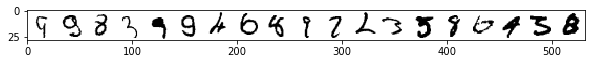

正確率 = 0.962000(19/500)


In [65]:
print("\t[Info] Error analysis:")
wrong_num = 0
img = np.array([])

for i in range(len(test_X1)):
    if ans[i] != test_y1[i]:
        print("\tAt %d'th: %d is with wrong prediction as %d!"
              % (i, test_y1[i], ans[i]))
        if wrong_num == 0:
            img = np.array(test_X1[i])
        else:
            img = np.concatenate((img, test_X1[i]), axis=1)
        wrong_num += 1
        # plot_img(test_X1[i])
print("所有錯誤圖片:")
plot_img(img)
print("正確率 = %f(%d/%d)" % ((1-(wrong_num/len(test_X1))),
                           wrong_num, len(test_X1)))

---

# Practice 1
1. 把RNN cell換成LSTM觀察Accuracy是否會上升? (hint: tf.nn.rnn_cell.BasicLSTMCell)
2. 把RNN cell換成GRU觀察Accuracy是否會上升? (hint: tf.nn.rnn_cell.GRUCell)

#### answer is in MNIST_answer.ipynb